In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math
import random

import pydot
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

from IPython.display import Image

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.externals.six import StringIO  
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report

from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.anova import anova_lm
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

%matplotlib inline
plt.style.use('seaborn-white')

In [7]:
# This function creates images of tree models using pydot
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)

def show_grid_search(model, X_train, y_train, tuned_parameters, scores):
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(
            model, tuned_parameters, cv=3,
            scoring='%s_macro' % score, n_jobs=-1
        )
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()

# function for printing the ROC curve
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [8]:
# Load data
df = pd.read_csv("nhl_game_data/game_teams_stats.csv")
# normalize 
df['shots'] = (df['shots'] - df['shots'].mean()) / (df['shots'].max() - df['shots'].min())
df['goals'] = (df['goals'] - df['goals'].mean()) / (df['goals'].max() - df['goals'].min())
df['pim'] = (df['pim'] - df['pim'].mean()) / (df['pim'].max() - df['pim'].min())
df['powerPlayGoals'] = (df['powerPlayGoals'] - df['powerPlayGoals'].mean()) / (df['powerPlayGoals'].max() - df['powerPlayGoals'].min())
df['giveaways'] = (df['giveaways'] - df['giveaways'].mean()) / (df['giveaways'].max() - df['giveaways'].min())
df['takeaways'] = (df['takeaways'] - df['takeaways'].mean()) / (df['takeaways'].max() - df['takeaways'].min())
df['faceOffWinPercentage'] = (df['faceOffWinPercentage'] - df['faceOffWinPercentage'].mean()) / (df['faceOffWinPercentage'].max() - df['faceOffWinPercentage'].min())

# Change catergorical data to numerical
df['won_true'] = df['won'].astype(int)
# Features
X = df[['goals', 'shots', 'pim', 'powerPlayGoals', 'giveaways', 'takeaways', 'faceOffWinPercentage']]
# Target Variable
y = df['won_true']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

All models will be trained and tested on the same sets.

In [10]:
svc = SVC()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
bc = BaggingClassifier()

We will start with an SVC model parameter tuning. 

In [11]:
# Select the optimal C, kernel and gamma parameter by cross-validation
tuned_parameters = [{'kernel':('rbf', 'poly', 'sigmoid'), 'C':(0.0001, 0.001, 0.01, .1, 1, 10),
                    'gamma':(0.01, 0.1, 1, 10)}]
#clf = GridSearchCV(svc, tuned_parameters, n_jobs=-1, cv=3, scoring='accuracy', verbose=10)
scores = ['precision', 'recall']
show_grid_search(svc, X_train, y_train, tuned_parameters, scores)

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}

Grid scores on development set:

0.251 (+/-0.000) for {'C': 0.0001, 'gamma': 0.01, 'kernel': 'rbf'}
0.251 (+/-0.000) for {'C': 0.0001, 'gamma': 0.01, 'kernel': 'poly'}
0.251 (+/-0.000) for {'C': 0.0001, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.251 (+/-0.000) for {'C': 0.0001, 'gamma': 0.1, 'kernel': 'rbf'}
0.251 (+/-0.000) for {'C': 0.0001, 'gamma': 0.1, 'kernel': 'poly'}
0.251 (+/-0.000) for {'C': 0.0001, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.251 (+/-0.000) for {'C': 0.0001, 'gamma': 1, 'kernel': 'rbf'}
0.251 (+/-0.000) for {'C': 0.0001, 'gamma': 1, 'kernel': 'poly'}
0.251 (+/-0.000) for {'C': 0.0001, 'gamma': 1, 'kernel': 'sigmoid'}
0.251 (+/-0.000) for {'C': 0.0001, 'gamma': 10, 'kernel': 'rbf'}
0.745 (+/-0.007) for {'C': 0.0001, 'gamma': 10, 'kernel': 'poly'}
0.251 (+/-0.000) for {'C': 0.0001, 'gamma': 10, 'kernel': 'sigmoid'}
0.251 (+/-0.000) for {'C': 0.001

C:\Users\jkom8\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best parameters set found on development set:

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}

Grid scores on development set:

0.500 (+/-0.000) for {'C': 0.0001, 'gamma': 0.01, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 0.0001, 'gamma': 0.01, 'kernel': 'poly'}
0.500 (+/-0.000) for {'C': 0.0001, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.500 (+/-0.000) for {'C': 0.0001, 'gamma': 0.1, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 0.0001, 'gamma': 0.1, 'kernel': 'poly'}
0.500 (+/-0.000) for {'C': 0.0001, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.500 (+/-0.000) for {'C': 0.0001, 'gamma': 1, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 0.0001, 'gamma': 1, 'kernel': 'poly'}
0.500 (+/-0.000) for {'C': 0.0001, 'gamma': 1, 'kernel': 'sigmoid'}
0.500 (+/-0.000) for {'C': 0.0001, 'gamma': 10, 'kernel': 'rbf'}
0.527 (+/-0.003) for {'C': 0.0001, 'gamma': 10, 'kernel': 'poly'}
0.500 (+/-0.000) for {'C': 0.0001, 'gamma': 10, 'kernel': 'sigmoid'}
0.500 (+/-0.000) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
0.500 (

The best parameters have been shown above for an SVC model.
They are the same for both precision and recall.

In [12]:
svc_precision_recall = SVC(kernel='rbf', C=0.1, gamma=1, probability=True)
svc_precision_recall.fit(X_train, y_train)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [13]:
pred = svc_precision_recall.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, pred))

Accuracy: 0.7778749453432444


In [14]:
confusion_matrix(y_test, pred)

array([[2680,  733],
       [ 791, 2657]], dtype=int64)

ROC for SCV:

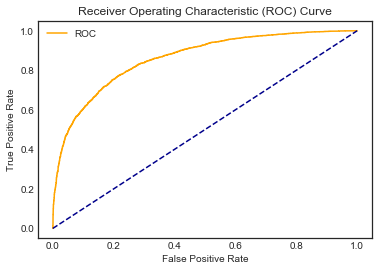

0.8598579081755782

In [15]:
y_probs = svc_precision_recall.predict_proba(X_test) # we have to get the probability values to plot roc curve
y_probs = y_probs[:, 1] # keep probabilities for the positive outcome only
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plot_roc_curve(fpr, tpr)
svc_auc = roc_auc_score(y_test, y_probs)
svc_auc

Lets move onto a Decision Tree Classifier model.

In [16]:
tuned_parameters = [{'criterion':('gini', 'entropy'),
                    'splitter':('best', 'random'),
                    'max_features':('auto', 'sqrt', 'log2'),
                    'max_leaf_nodes':(10, 25, 50, 100, 150),
                    'class_weight':['balanced']},
                   {'criterion':('gini', 'entropy'),
                    'splitter':('best', 'random')}]

show_grid_search(dtc, X_train, y_train, tuned_parameters, scores)

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'max_leaf_nodes': 25, 'splitter': 'best'}

Grid scores on development set:

0.772 (+/-0.006) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'max_leaf_nodes': 10, 'splitter': 'best'}
0.693 (+/-0.147) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'max_leaf_nodes': 10, 'splitter': 'random'}
0.703 (+/-0.036) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'max_leaf_nodes': 25, 'splitter': 'best'}
0.704 (+/-0.068) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'max_leaf_nodes': 25, 'splitter': 'random'}
0.758 (+/-0.023) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'max_leaf_nodes': 50, 'splitter': 'best'}
0.729 (+/-0.063) for {'class_weight': 'balanced', 'criterion': 'gini', 'm

Best parameters set found on development set:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'splitter': 'best'}

Grid scores on development set:

0.766 (+/-0.017) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'max_leaf_nodes': 10, 'splitter': 'best'}
0.645 (+/-0.214) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'max_leaf_nodes': 10, 'splitter': 'random'}
0.727 (+/-0.128) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'max_leaf_nodes': 25, 'splitter': 'best'}
0.596 (+/-0.016) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'max_leaf_nodes': 25, 'splitter': 'random'}
0.710 (+/-0.019) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'max_leaf_nodes': 50, 'splitter': 'best'}
0.691 (+/-0.120) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'max_leaf_nodes'

The best parameters have been shown above for a Decision Tree Classifier model.
They are different for precision and recall.
Both models are created and compared below.

In [17]:
#Precision best params: 
#{'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'max_leaf_nodes': 25, 'splitter': 'best'}
dtc_precision = DecisionTreeClassifier(class_weight='balanced', criterion= 'entropy', max_features= 'log2', max_leaf_nodes= 25, splitter= 'best')
dtc_precision.fit(X_train, y_train)
#Recall best params: 
#{'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'max_leaf_nodes': 10, 'splitter': 'best'}
dtc_recall = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_features='log2', max_leaf_nodes=10, splitter='best')
dtc_recall.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
                       max_depth=None, max_features='log2', max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [18]:
#Predict the response for test dataset
pred_precision = dtc_precision.predict(X_test)
print("Precision - Accuracy:", metrics.accuracy_score(y_test, pred_precision))
pred_recall = dtc_recall.predict(X_test)
print("Recall - Accuracy:", metrics.accuracy_score(y_test, pred_recall))

Precision - Accuracy: 0.7595102754700481
Recall - Accuracy: 0.7545547296312491


In [19]:
#Confusion matric with the most accurate of the two best models.
confusion_matrix(y_test, pred_recall)

array([[2331, 1082],
       [ 602, 2846]], dtype=int64)

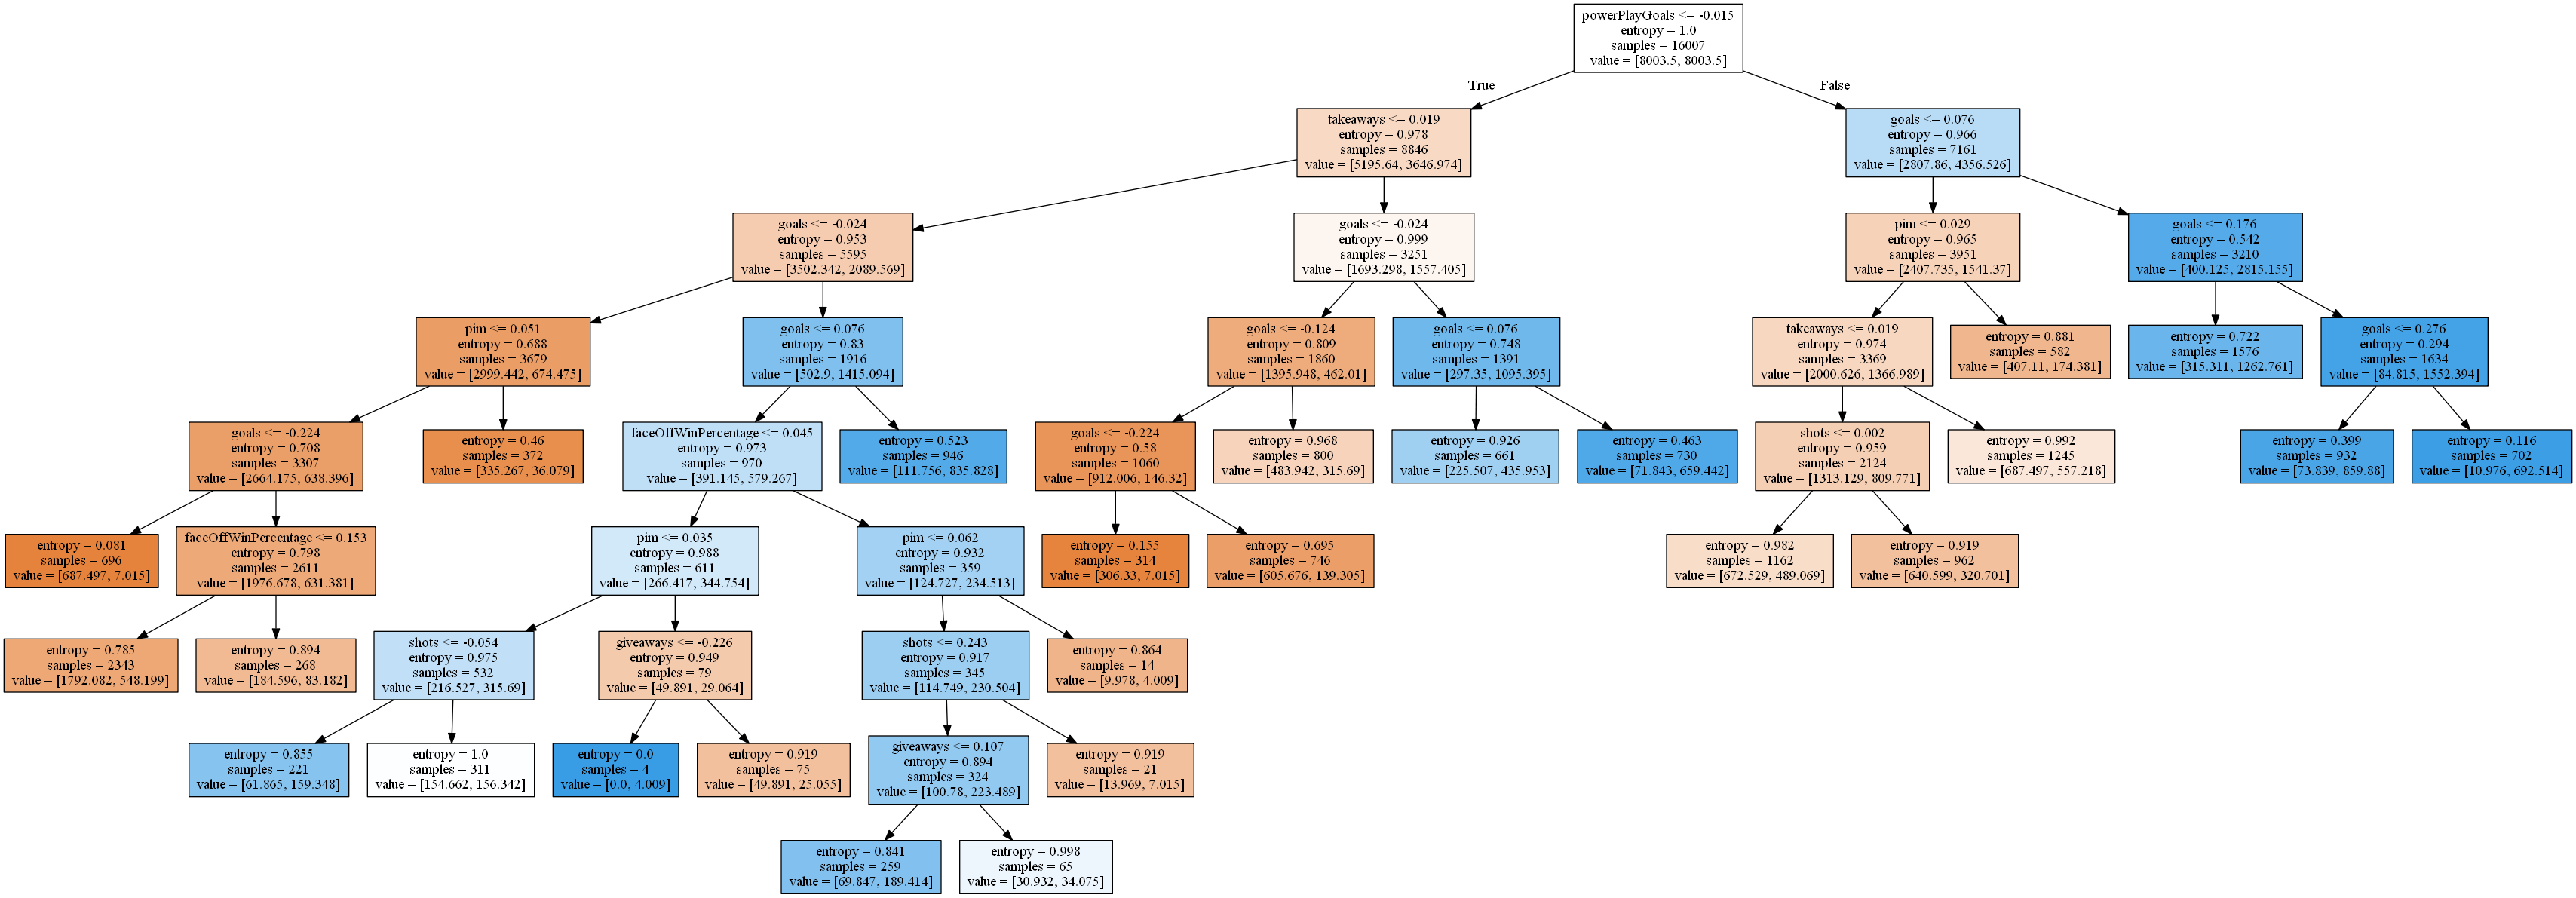

In [20]:
graph, = print_tree(dtc_precision, features=['goals', 'shots', 'pim', 'powerPlayGoals', 'giveaways', 'takeaways', 'faceOffWinPercentage'])
Image(graph.create_png())

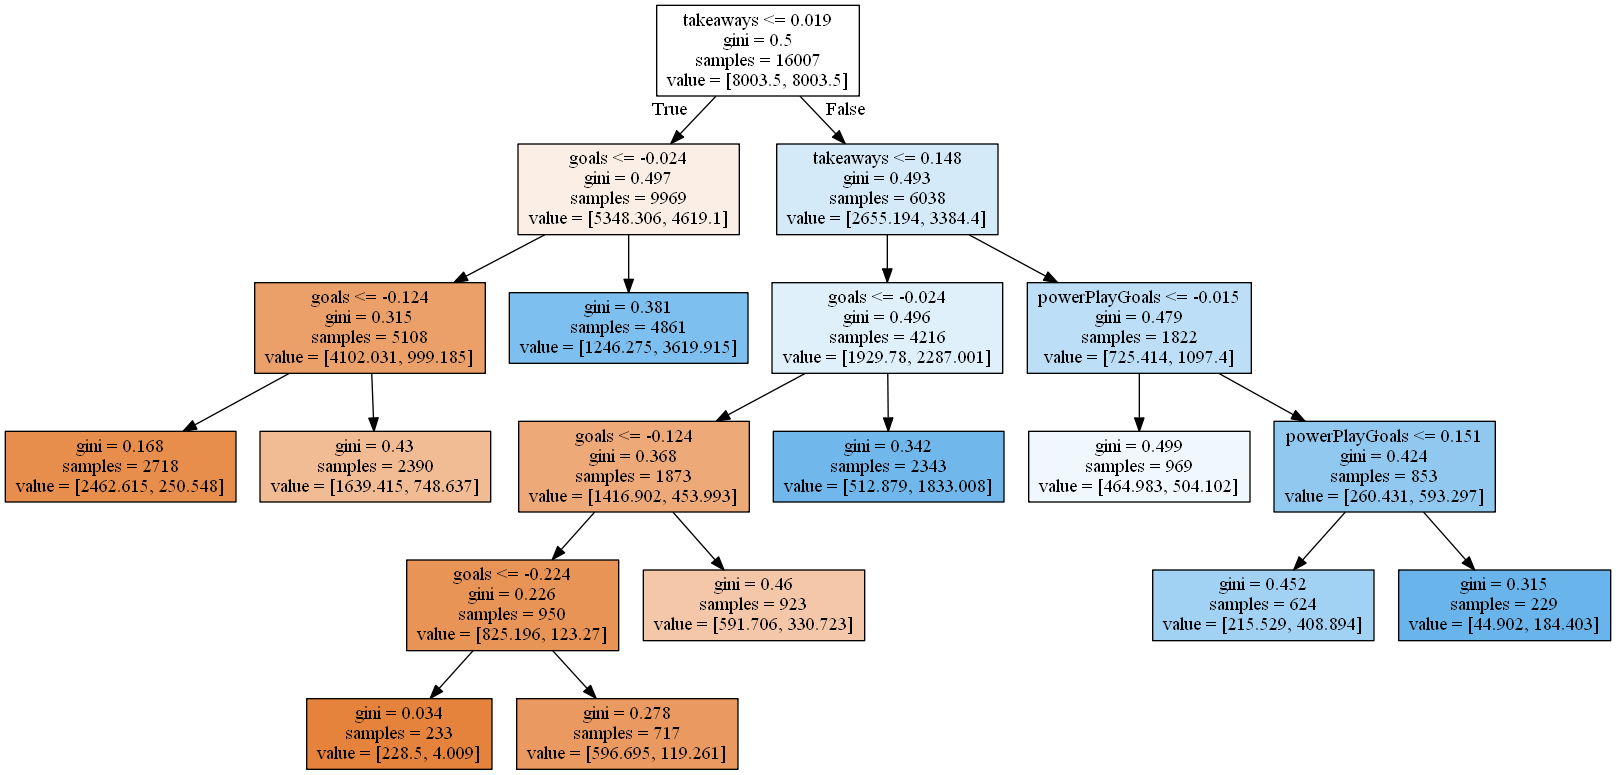

In [21]:
graph, = print_tree(dtc_recall, features=['goals', 'shots', 'pim', 'powerPlayGoals', 'giveaways', 'takeaways', 'faceOffWinPercentage'])
Image(graph.create_png())

ROC for DTC Precision:

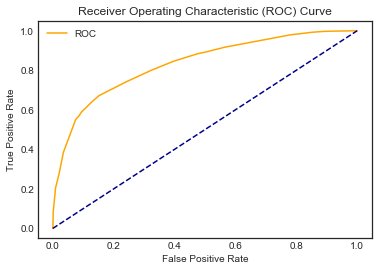

0.8325493727749026

In [22]:
y_probs = dtc_precision.predict_proba(X_test) # we have to get the probability values to plot roc curve
y_probs = y_probs[:, 1] # keep probabilities for the positive outcome only
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plot_roc_curve(fpr, tpr)
dtc_precision_auc = roc_auc_score(y_test, y_probs)
dtc_precision_auc

ROC for DTC Recall:

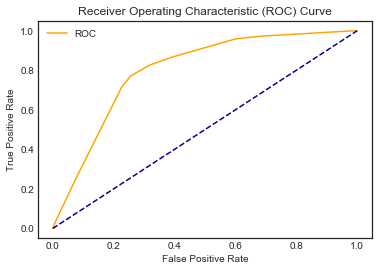

0.7994126286622121

In [23]:
y_probs = dtc_recall.predict_proba(X_test) # we have to get the probability values to plot roc curve
y_probs = y_probs[:, 1] # keep probabilities for the positive outcome only
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plot_roc_curve(fpr, tpr)
dtc_recall_auc = roc_auc_score(y_test, y_probs)
dtc_recall_auc

Next, we will look at a Random Forest Classifier. 

In [24]:
tuned_parameters = [{'n_estimators':(10, 50, 100, 200, 500),
                    'criterion':('gini', 'entropy')}]

show_grid_search(rfc, X_train, y_train, tuned_parameters, scores)

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'criterion': 'entropy', 'n_estimators': 500}

Grid scores on development set:

0.745 (+/-0.004) for {'criterion': 'gini', 'n_estimators': 10}
0.760 (+/-0.007) for {'criterion': 'gini', 'n_estimators': 50}
0.762 (+/-0.007) for {'criterion': 'gini', 'n_estimators': 100}
0.764 (+/-0.007) for {'criterion': 'gini', 'n_estimators': 200}
0.764 (+/-0.005) for {'criterion': 'gini', 'n_estimators': 500}
0.745 (+/-0.005) for {'criterion': 'entropy', 'n_estimators': 10}
0.761 (+/-0.007) for {'criterion': 'entropy', 'n_estimators': 50}
0.763 (+/-0.010) for {'criterion': 'entropy', 'n_estimators': 100}
0.764 (+/-0.004) for {'criterion': 'entropy', 'n_estimators': 200}
0.765 (+/-0.007) for {'criterion': 'entropy', 'n_estimators': 500}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score 

In [25]:
#Precision best params: 
#{'criterion': 'entropy', 'n_estimators': 500}
#Recall best params: 
#{'criterion': 'entropy', 'n_estimators': 500}
rfc_precision_recall = RandomForestClassifier(n_estimators=500, criterion='entropy')
rfc_precision_recall.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [26]:
pred_precision_recall = rfc_precision_recall.predict(X_test)
print("Precision - Accuracy:", metrics.accuracy_score(y_test, pred_precision_recall))
#pred_recall = rfc_recall.predict(X_test)
#print("Recall - Accuracy:", metrics.accuracy_score(y_test, pred_recall))

Precision - Accuracy: 0.7681096050138464


In [27]:
#Confusion matric with the most accurate of the two best models.
confusion_matrix(y_test, pred_precision_recall)

array([[2621,  792],
       [ 799, 2649]], dtype=int64)

ROC for RFC:

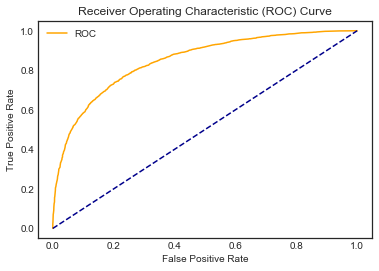

0.8480738567494424

In [28]:
y_probs = rfc_precision_recall.predict_proba(X_test) # we have to get the probability values to plot roc curve
y_probs = y_probs[:, 1] # keep probabilities for the positive outcome only
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plot_roc_curve(fpr, tpr)
rfc_precision_recall_auc = roc_auc_score(y_test, y_probs)
rfc_precision_recall_auc

In [29]:
""""
y_probs = rfc_recall.predict_proba(X_test) # we have to get the probability values to plot roc curve
y_probs = y_probs[:, 1] # keep probabilities for the positive outcome only
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plot_roc_curve(fpr, tpr)
rfc_recall_auc = roc_auc_score(y_test, y_probs)
rfc_recall_auc
""""

SyntaxError: EOL while scanning string literal (<ipython-input-29-5db79a297ecb>, line 9)

Last, lets look at the Bagging Classifier model.

In [30]:
tuned_parameters = [{'n_estimators':(1, 5, 10, 20, 50),
                    'bootstrap':[True],
                    'bootstrap_features':(True, False),
                    'oob_score':[True],
                    'warm_start':[False]},
                   {'n_estimators':(1, 5, 10, 20, 50),
                    'bootstrap':(True, False),
                    'bootstrap_features':(True, False),
                    'oob_score':[False],
                    'warm_start':[True]}]

show_grid_search(bc, X_train, y_train, tuned_parameters, scores)

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'bootstrap': True, 'bootstrap_features': False, 'n_estimators': 50, 'oob_score': False, 'warm_start': True}

Grid scores on development set:

0.634 (+/-0.146) for {'bootstrap': True, 'bootstrap_features': True, 'n_estimators': 1, 'oob_score': True, 'warm_start': False}
0.727 (+/-0.045) for {'bootstrap': True, 'bootstrap_features': True, 'n_estimators': 5, 'oob_score': True, 'warm_start': False}
0.719 (+/-0.015) for {'bootstrap': True, 'bootstrap_features': True, 'n_estimators': 10, 'oob_score': True, 'warm_start': False}
0.741 (+/-0.014) for {'bootstrap': True, 'bootstrap_features': True, 'n_estimators': 20, 'oob_score': True, 'warm_start': False}
0.749 (+/-0.008) for {'bootstrap': True, 'bootstrap_features': True, 'n_estimators': 50, 'oob_score': True, 'warm_start': False}
0.679 (+/-0.008) for {'bootstrap': True, 'bootstrap_features': False, 'n_estimators': 1, 'oob_score': True, 'warm_start': Fals

In [31]:
#Best params for precision:
#{'bootstrap': True, 'bootstrap_features': False, 'n_estimators': 50, 'oob_score': True, 'warm_start': False}
bc_precision = BaggingClassifier(n_estimators=50, bootstrap=True, bootstrap_features=False, oob_score=True, warm_start=False)
bc_precision.fit(X_train, y_train)
#Best params for recall:
#{'bootstrap': True, 'bootstrap_features': False, 'n_estimators': 50, 'oob_score': False, 'warm_start': True}
bc_recall = BaggingClassifier(n_estimators=50, bootstrap=True, bootstrap_features=True, oob_score=False, warm_start=True)
bc_recall.fit(X_train, y_train)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=True,
                  max_features=1.0, max_samples=1.0, n_estimators=50,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=True)

In [32]:
pred_precision = bc_precision.predict(X_test)
print("Precision - Accuracy:", metrics.accuracy_score(y_test, pred_precision))
pred_recall = bc_recall.predict(X_test)
print("Recall - Accuracy:", metrics.accuracy_score(y_test, pred_recall))

Precision - Accuracy: 0.7555749890686488
Recall - Accuracy: 0.7570325025506486


In [33]:
#Confusion matric with the most accurate of the two best models.
confusion_matrix(y_test, pred_precision)

array([[2590,  823],
       [ 854, 2594]], dtype=int64)

ROC for BC Precision:

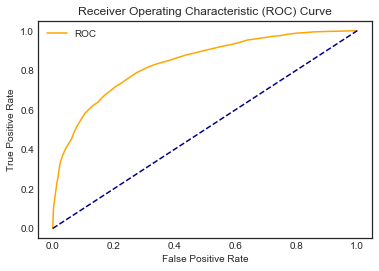

0.835806929013741

In [34]:
y_probs = bc_precision.predict_proba(X_test) # we have to get the probability values to plot roc curve
y_probs = y_probs[:, 1] # keep probabilities for the positive outcome only
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plot_roc_curve(fpr, tpr)
bc_precision_auc = roc_auc_score(y_test, y_probs)
bc_precision_auc

ROC for BC Recall:

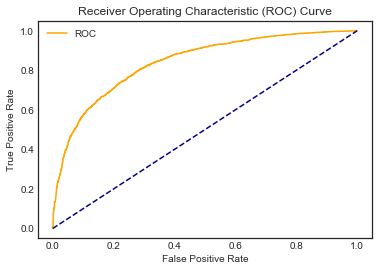

0.8401455503489796

In [35]:
y_probs = bc_recall.predict_proba(X_test) # we have to get the probability values to plot roc curve
y_probs = y_probs[:, 1] # keep probabilities for the positive outcome only
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plot_roc_curve(fpr, tpr)
bc_recall_auc = roc_auc_score(y_test, y_probs)
bc_recall_auc

dtc_precision: 0.730372 (0.045661)
dtc_recall: 0.717750 (0.051746)
SVM: 0.777160 (0.007921)
rfc: 0.764540 (0.008220)
BC_precision: 0.754856 (0.007209)
BC_recall: 0.750234 (0.007244)


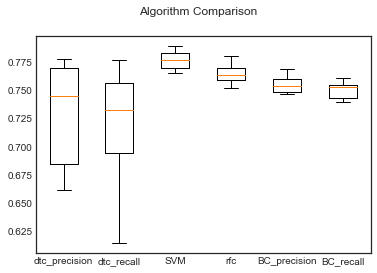

In [36]:
from sklearn import model_selection


# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('dtc_precision', dtc_precision))
models.append(('dtc_recall', dtc_recall))
models.append(('SVM', svc_precision_recall))
models.append(('rfc', rfc_precision_recall))
models.append(('BC_precision', bc_precision))
models.append(('BC_recall', bc_recall))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()